In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, auc

In [94]:
# Load the built-in Titanic dataset from Seaborn into a pandas DataFrame
df = sns.load_dataset('titanic')

# Display the first five rows of the DataFrame to preview the dataset
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [95]:
# Display a concise summary of the DataFrame including column names, data types, and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [96]:
# Return the number of rows and columns in the DataFrame as a tuple (rows, columns)
df.shape

(891, 15)

In [97]:
# Count the total number of missing (NaN) values in each column of the DataFrame
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [98]:
# Count the number of duplicate rows in the DataFrame
df.duplicated().sum()

np.int64(107)

In [99]:
# Remove all duplicate rows from the DataFrame and update df
df = df.drop_duplicates()

# Check the new shape of the DataFrame after removing duplicates
df.shape

(784, 15)

In [100]:
# Drop the 'embarked' and 'deck' columns from the DataFrame as they are not needed
df = df.drop(['embarked', 'deck'], axis=1)

# Fill missing values in the 'age' column with the column's mean value
df['age'] = df['age'].fillna(df['age'].mean())

# Fill missing values in the 'embark_town' column using forward fill method
df['embark_town'] = df['embark_town'].ffill()

In [101]:
# Initialize an empty dictionary to store the number of outliers for each numerical column
outlier_count = {}

# Loop through all numerical columns in the DataFrame
for col in df.select_dtypes(include='number').columns:
    # Calculate the first quartile (25th percentile) of the column
    q1 = df[col].quantile(.25)
    
    # Calculate the third quartile (75th percentile) of the column
    q3 = df[col].quantile(.75)

    # Compute the interquartile range (IQR)
    iqr = q3 - q1

    # Determine the upper whisker (1.5*IQR above Q3)
    upper_whisker = q3 + 1.5 * iqr
    
    # Determine the lower whisker (1.5*IQR below Q1)
    lower_whisker = q1 - 1.5 * iqr

    # Count the number of outliers in the column
    counts = (df[col] > upper_whisker) | (df[col] < lower_whisker)
    outlier_count[col] = counts.sum()

# Convert the outlier count dictionary into a DataFrame for better visualization
outlier_df  = pd.DataFrame(
    {
        'Columns': outlier_count.keys(),      # Column names
        'Outlier Count': outlier_count.values()  # Corresponding number of outliers
    }
)

# Display the DataFrame showing number of outliers per numerical column
outlier_df

,Columns,Outlier Count
0,survived,0
1,pclass,0
2,age,39
3,sibsp,39
4,parch,15
5,fare,102


In [102]:
# Define a function to handle outliers in a numerical column using the IQR method
def outlier(df, col2):
    
    # Calculate the first quartile (25th percentile) of the selected column
    q1 = df[col2].quantile(.25)
    # Calculate the third quartile (75th percentile) of the selected column
    q3 = df[col2].quantile(.75)

    # Compute the interquartile range (IQR)
    iqr = q3 - q1

    # Define the upper boundary for outlier capping
    upper_whisker = q3 + 1.5 * iqr
    # Define the lower boundary for outlier capping
    lower_whisker = q1 - 1.5 * iqr

    # Cap the outliers by clipping values outside the IQR range
    df[col2] = np.clip(df[col2], lower_whisker, upper_whisker)
    
    # Return the updated DataFrame with outliers handled
    return df


In [103]:
# Create a copy of the original DataFrame to preserve the raw data
df_clean = df.copy()

# Apply the outlier handling function to each numerical column
for col4 in df.select_dtypes(include='number').columns:
    
    # Cap outliers in the current numerical column using the IQR method
    df_clean = outlier(df_clean, col4)

# Replace the original DataFrame with the cleaned version
df = df_clean.copy()

Visualization

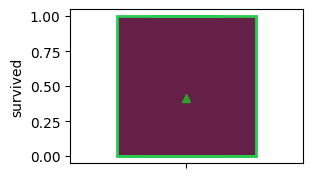

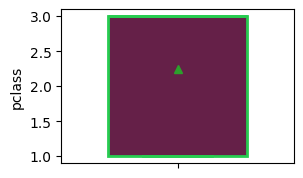

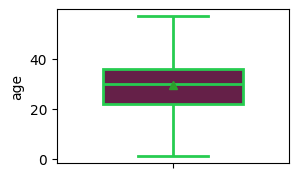

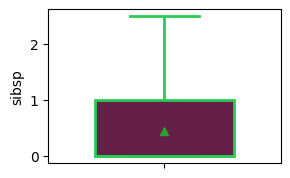

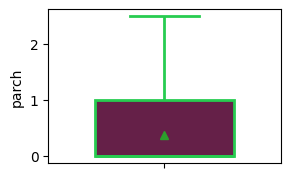

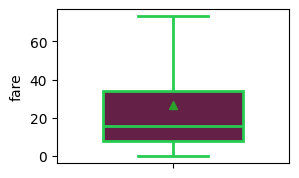

In [105]:
# Loop through all numerical columns in the DataFrame to visualize outliers
for col3 in df.select_dtypes(include='number').columns:
    
    # Create a new figure with a fixed size for each boxplot
    plt.figure(figsize=(3,2))
    
    # Draw a boxplot for the current numerical column to visualize distribution and outliers
    sns.boxplot(
        df[col3],              # Data for the boxplot
        color="#70154A",        # Set the fill color of the box
        linecolor="#27CC50",    # Set the color of the box edges and whiskers
        linewidth=2,            # Define the thickness of box edges
        showmeans=True,         # Display the mean value on the boxplot
        width=0.6               # Control the width of the box
    )
    
    # Display the boxplot for the current column
    plt.show()

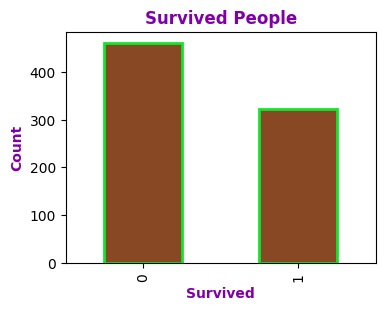

In [113]:
plt.figure(figsize=(4,3))
df['survived'].value_counts().plot(
    kind='bar',
    color='#894824',
    edgecolor="#0FE72C",
    linewidth=2
)
plt.title('Survived People', color="#8000A7", fontweight='bold')
plt.xlabel('Survived', color="#8000A7", fontweight='bold')
plt.ylabel('Count', color="#8000A7", fontweight='bold')
plt.show()

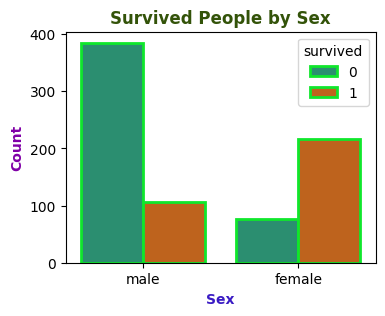

In [119]:
plt.figure(figsize=(4,3))
sns.countplot(
    data=df,
    x='sex',
    hue='survived',
    palette='Dark2',
    #color='#894824',
    edgecolor="#0FE72C",
    linewidth=2
)
plt.title('Survived People by Sex', color="#335309", fontweight='bold')
plt.xlabel('Sex', color="#3A1BC4", fontweight='bold')
plt.ylabel('Count', color="#8000A7", fontweight='bold')
plt.show()